In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import sys, cv2
import numpy as np
import matplotlib.pyplot as plt



class DCGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        optimizer = Adam(2e-4, 0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        
        self.generator = self.build_generator()
        
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):
        
        input_layer = Input(shape=(self.latent_dim,))
        layer1 = Dense(128 * 7 * 7, activation='relu')(input_layer)
        layer2 = Reshape((7,7,128))(layer1)
        layer3 = UpSampling2D()(layer2)
        layer4 = Conv2D(128, kernel_size=(3,3), padding='same')(layer3)
        layer5 = BatchNormalization()(layer4)
        layer6 = Activation('relu')(layer5)
        
        layer7 = UpSampling2D()(layer6)
        layer8 = Conv2D(64, kernel_size=(3,3), padding='same')(layer7)
        layer9 = BatchNormalization()(layer8)
        layer10 = Activation('relu')(layer9)
        
        layer11 = Conv2D(self.channels, kernel_size=(3,3), padding='same')(layer10)
        output_layer = Activation('tanh')(layer11)
        
        return Model(input_layer, output_layer)
    
    def build_discriminator(self):
        
        input_layer = Input(shape=self.img_shape)
        layer1 = Conv2D(32, kernel_size=(3,3), strides=2, padding='same')(input_layer)
        layer2 = Activation('relu')(layer1)
        layer3 = Dropout(0.25)(layer2)
        
        layer4 = Conv2D(63, kernel_size=(3,3), strides=2, padding='same')(layer3)
        layer5 = ZeroPadding2D(padding=((0,1),(0,1)))(layer4)
        layer6 = BatchNormalization()(layer5)
        layer7 = Activation('relu')(layer6)
        layer8 = Dropout(0.25)(layer7)
        
        layer9 = Conv2D(128, kernel_size=(3,3), strides=2, padding='same')(layer8)
        layer10 = BatchNormalization()(layer9)
        layer11 = Activation('relu')(layer10)
        layer12 = Dropout(0.25)(layer11)
        
        layer13 = Conv2D(256, kernel_size=(3,3), strides=1, padding='same')(layer12)
        layer14 = BatchNormalization()(layer13)
        layer15 = Activation('relu')(layer14)
        layer16 = Dropout(0.25)(layer15)
        layer17 = Flatten()(layer16)
        output_layer = Dense(1, activation='sigmoid')(layer17)
        
        return Model(input_layer, output_layer)
    
    
    def train(self, epochs, batch_size=128, save_interval=50):
        
        (X_train, _), (_, _) = mnist.load_data()
        
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0,1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            g_loss = self.combined.train_on_batch(noise, valid)
            
            print(f'{epoch} [D loss: {d_loss[0]}, acc: {100 * d_loss[1]}] [G loss: {g_loss}]')
            
            
        
        
        
        
        
        



In [2]:
dcgan = DCGAN()



2022-04-07 19:56:44.157879: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-07 19:56:46.230562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22320 MB memory:  -> device: 0, name: RTX A5000, pci bus id: 0000:05:00.0, compute capability: 8.6
2022-04-07 19:56:46.231937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22334 MB memory:  -> device: 1, name: RTX A5000, pci bus id: 0000:06:00.0, compute capability: 8.6
2022-04-07 19:56:46.233227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU

In [3]:
dcgan.train(epochs=400, batch_size=32, save_interval=50)

2022-04-07 19:56:47.131870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-07 19:56:47.996333: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-07 19:56:48.579707: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


0 [D loss: 1.2389166802167892, acc: 39.0625] [G loss: 0.6879020929336548]
1 [D loss: 0.8861437141895294, acc: 59.375] [G loss: 0.6946169137954712]
2 [D loss: 0.5522360503673553, acc: 67.1875] [G loss: 0.6977595090866089]
3 [D loss: 0.49794766306877136, acc: 76.5625] [G loss: 0.7005443572998047]
4 [D loss: 0.5096280574798584, acc: 73.4375] [G loss: 0.7006505131721497]
5 [D loss: 0.4514674246311188, acc: 84.375] [G loss: 0.6956616640090942]
6 [D loss: 0.299696683883667, acc: 95.3125] [G loss: 0.7045925259590149]
7 [D loss: 0.28804436326026917, acc: 92.1875] [G loss: 0.7084536552429199]
8 [D loss: 0.1496422365307808, acc: 100.0] [G loss: 0.7105497121810913]
9 [D loss: 0.14555950090289116, acc: 100.0] [G loss: 0.7151250839233398]
10 [D loss: 0.15787700563669205, acc: 98.4375] [G loss: 0.7058273553848267]
11 [D loss: 0.11375758051872253, acc: 100.0] [G loss: 0.7026296854019165]
12 [D loss: 0.07991432771086693, acc: 100.0] [G loss: 0.7001388669013977]
13 [D loss: 0.08570095524191856, acc: 10

110 [D loss: 0.0038292520912364125, acc: 100.0] [G loss: 1.0120658874511719]
111 [D loss: 0.00806399097200483, acc: 100.0] [G loss: 1.0373015403747559]
112 [D loss: 0.009922729805111885, acc: 100.0] [G loss: 0.9647918939590454]
113 [D loss: 0.009766291826963425, acc: 100.0] [G loss: 0.9854315519332886]
114 [D loss: 0.01494155265390873, acc: 100.0] [G loss: 0.9951254725456238]
115 [D loss: 0.017418315168470144, acc: 100.0] [G loss: 0.9769214391708374]
116 [D loss: 0.031233537942171097, acc: 100.0] [G loss: 1.0248286724090576]
117 [D loss: 0.04511995427310467, acc: 100.0] [G loss: 1.2339370250701904]
118 [D loss: 0.1701466664671898, acc: 93.75] [G loss: 1.5916948318481445]
119 [D loss: 0.26889704167842865, acc: 89.0625] [G loss: 1.7817270755767822]
120 [D loss: 0.8558409512042999, acc: 51.5625] [G loss: 2.374485969543457]
121 [D loss: 2.337568700313568, acc: 17.1875] [G loss: 1.8650692701339722]
122 [D loss: 0.19452832452952862, acc: 90.625] [G loss: 1.657958745956421]
123 [D loss: 0.075

222 [D loss: 0.5227166563272476, acc: 73.4375] [G loss: 1.626849889755249]
223 [D loss: 0.6587716341018677, acc: 68.75] [G loss: 1.563387393951416]
224 [D loss: 0.9942512512207031, acc: 42.1875] [G loss: 1.7605345249176025]
225 [D loss: 1.2375567555427551, acc: 32.8125] [G loss: 1.7575554847717285]
226 [D loss: 0.9962105751037598, acc: 48.4375] [G loss: 1.847501277923584]
227 [D loss: 0.9519208669662476, acc: 54.6875] [G loss: 1.7461225986480713]
228 [D loss: 0.8710953295230865, acc: 56.25] [G loss: 1.3028271198272705]
229 [D loss: 0.5710256695747375, acc: 70.3125] [G loss: 1.3889235258102417]
230 [D loss: 0.4808673560619354, acc: 81.25] [G loss: 1.540945291519165]
231 [D loss: 0.7978066802024841, acc: 54.6875] [G loss: 1.7272393703460693]
232 [D loss: 0.9405014514923096, acc: 46.875] [G loss: 1.5320143699645996]
233 [D loss: 0.7421748638153076, acc: 50.0] [G loss: 1.4140533208847046]
234 [D loss: 0.961579829454422, acc: 40.625] [G loss: 1.2796634435653687]
235 [D loss: 0.6367651522159

333 [D loss: 0.5389081239700317, acc: 65.625] [G loss: 1.025857925415039]
334 [D loss: 0.6388333737850189, acc: 57.8125] [G loss: 0.8479042053222656]
335 [D loss: 0.6865327656269073, acc: 60.9375] [G loss: 1.0246787071228027]
336 [D loss: 0.6989003270864487, acc: 60.9375] [G loss: 0.7010567784309387]
337 [D loss: 0.527351588010788, acc: 71.875] [G loss: 0.8878388404846191]
338 [D loss: 0.6525053381919861, acc: 62.5] [G loss: 0.8787410855293274]
339 [D loss: 0.46767382323741913, acc: 75.0] [G loss: 0.7762665748596191]
340 [D loss: 0.4303409457206726, acc: 81.25] [G loss: 1.0130521059036255]
341 [D loss: 0.4795249402523041, acc: 76.5625] [G loss: 0.9311296343803406]
342 [D loss: 0.3951353430747986, acc: 89.0625] [G loss: 0.9563773274421692]
343 [D loss: 0.6289499402046204, acc: 65.625] [G loss: 0.7672123908996582]
344 [D loss: 0.6131774485111237, acc: 62.5] [G loss: 1.1707532405853271]
345 [D loss: 0.764176070690155, acc: 54.6875] [G loss: 0.9566708207130432]
346 [D loss: 0.8815662264823

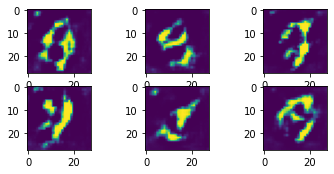

In [4]:
NUM_IMAGES = 6

noise = np.random.normal(0,1,(NUM_IMAGES,100))
gen_imgs = dcgan.generator.predict(noise)

for i in range(NUM_IMAGES):
    plt.subplot(NUM_IMAGES//2, NUM_IMAGES//2, i+1)
    plt.imshow(gen_imgs[i,:,:,0])
plt.show()

0 [D loss: 0.7498471140861511, acc: 51.5625] [G loss: 1.036842703819275]
1 [D loss: 0.7637194097042084, acc: 59.375] [G loss: 0.8340024948120117]
2 [D loss: 0.4297039657831192, acc: 82.8125] [G loss: 1.0976910591125488]
3 [D loss: 0.3518216609954834, acc: 89.0625] [G loss: 0.9971468448638916]
4 [D loss: 0.7536017894744873, acc: 51.5625] [G loss: 0.9339839220046997]
5 [D loss: 0.5905032455921173, acc: 75.0] [G loss: 0.6783531904220581]
6 [D loss: 0.6365715265274048, acc: 67.1875] [G loss: 0.8422228097915649]
7 [D loss: 0.5395908057689667, acc: 71.875] [G loss: 0.7970082759857178]
8 [D loss: 0.46132829040288925, acc: 76.5625] [G loss: 0.8727628588676453]
9 [D loss: 0.5661535263061523, acc: 65.625] [G loss: 1.0326271057128906]
10 [D loss: 0.3371831029653549, acc: 84.375] [G loss: 1.0828709602355957]
11 [D loss: 0.7471281290054321, acc: 62.5] [G loss: 0.8455730080604553]
12 [D loss: 0.6262158453464508, acc: 65.625] [G loss: 1.039971113204956]
13 [D loss: 0.6870571076869965, acc: 54.6875] [

112 [D loss: 0.38139913976192474, acc: 84.375] [G loss: 0.9565463066101074]
113 [D loss: 0.44759686291217804, acc: 81.25] [G loss: 1.0360822677612305]
114 [D loss: 0.3727535754442215, acc: 84.375] [G loss: 1.1577250957489014]
115 [D loss: 0.38034725189208984, acc: 89.0625] [G loss: 1.0718296766281128]
116 [D loss: 0.5931489169597626, acc: 71.875] [G loss: 1.2906639575958252]
117 [D loss: 0.579766035079956, acc: 70.3125] [G loss: 1.2527174949645996]
118 [D loss: 0.7468932569026947, acc: 57.8125] [G loss: 1.2028188705444336]
119 [D loss: 0.9682443737983704, acc: 43.75] [G loss: 1.2378530502319336]
120 [D loss: 1.0092876255512238, acc: 34.375] [G loss: 1.5729942321777344]
121 [D loss: 0.7128452658653259, acc: 60.9375] [G loss: 1.2775132656097412]
122 [D loss: 0.27272751927375793, acc: 98.4375] [G loss: 1.1904683113098145]
123 [D loss: 0.729645699262619, acc: 53.125] [G loss: 1.3878107070922852]
124 [D loss: 0.8672594428062439, acc: 51.5625] [G loss: 1.3666256666183472]
125 [D loss: 0.9094

221 [D loss: 0.03839864442124963, acc: 100.0] [G loss: 0.7937884330749512]
222 [D loss: 0.1446269005537033, acc: 98.4375] [G loss: 0.6998685598373413]
223 [D loss: 0.06750763952732086, acc: 100.0] [G loss: 0.6510372757911682]
224 [D loss: 0.02415524050593376, acc: 100.0] [G loss: 0.623388409614563]
225 [D loss: 0.060297148302197456, acc: 100.0] [G loss: 0.5758417248725891]
226 [D loss: 0.15385304763913155, acc: 96.875] [G loss: 0.7278441190719604]
227 [D loss: 0.04765121964737773, acc: 100.0] [G loss: 0.7111109495162964]
228 [D loss: 0.06363643519580364, acc: 100.0] [G loss: 0.6032333374023438]
229 [D loss: 0.47560717165470123, acc: 79.6875] [G loss: 0.6871603727340698]
230 [D loss: 0.08982501178979874, acc: 96.875] [G loss: 0.7032433748245239]
231 [D loss: 0.1253371387720108, acc: 100.0] [G loss: 0.7476289868354797]
232 [D loss: 0.5098510533571243, acc: 76.5625] [G loss: 0.6347055435180664]
233 [D loss: 0.10430554673075676, acc: 98.4375] [G loss: 0.7802114486694336]
234 [D loss: 0.052

331 [D loss: 0.34380732476711273, acc: 85.9375] [G loss: 0.8830999732017517]
332 [D loss: 0.08766486123204231, acc: 100.0] [G loss: 1.0820101499557495]
333 [D loss: 0.1444765031337738, acc: 98.4375] [G loss: 0.8014560341835022]
334 [D loss: 0.3168008103966713, acc: 89.0625] [G loss: 1.0687049627304077]
335 [D loss: 0.4466569125652313, acc: 76.5625] [G loss: 0.812766969203949]
336 [D loss: 0.14566369354724884, acc: 98.4375] [G loss: 0.682681143283844]
337 [D loss: 0.062031909823417664, acc: 100.0] [G loss: 0.5881059169769287]
338 [D loss: 0.06542576104402542, acc: 100.0] [G loss: 0.7283676862716675]
339 [D loss: 0.03779705427587032, acc: 100.0] [G loss: 0.8164795637130737]
340 [D loss: 0.09463534504175186, acc: 98.4375] [G loss: 0.6890057921409607]
341 [D loss: 0.1269061453640461, acc: 96.875] [G loss: 0.9169480204582214]
342 [D loss: 0.08492642268538475, acc: 100.0] [G loss: 0.9340857863426208]
343 [D loss: 0.2173113375902176, acc: 92.1875] [G loss: 0.743183970451355]
344 [D loss: 0.28

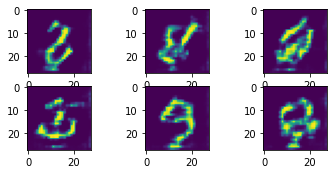

In [5]:
dcgan.train(epochs=400, batch_size=32, save_interval=50)
NUM_IMAGES = 6

noise = np.random.normal(0,1,(NUM_IMAGES,100))
gen_imgs = dcgan.generator.predict(noise)

for i in range(NUM_IMAGES):
    plt.subplot(NUM_IMAGES//2, NUM_IMAGES//2, i+1)
    plt.imshow(gen_imgs[i,:,:,0])
plt.show()